# Sentiment Analysis

---

In this small project I aim to train my skills with Spark on multiclass classification problems.

The project basically consists of sentiment analysis pipeline using kaggle dataset product reviews on this link: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews.

There is no strong business reason to solve any business problem involving the project, just for tool studies.
The main goal is clean and preprocess text data and represents this text in a vector for classic machine learning for classify three different labels (bad, neutral and good) scores of this text vector representation.

I tried classic NLP methods like tokenization, StopWords, TD-IDF, etc. In "Next Steps", I mention some improvements that I would make to the code, but at this moment I will not apply them as we are working within a cyclical development method.

![Alt text](image-4.png)

**Project Steps**

![Alt text](image-3.png)

The first step is the *Data Cleaning*, in this step I have used spark for cleaning texts with regex and built-in transformations.

The second step is the *Tokenization*, is the step of taking the already cleaned text and separating it into tokens, which are a list of words or chunks of separate words.

The third step is the *StopWordsRemover*, simple remove stop words ("a", "is"...) for each token.

The fourth step is the *TF-IDF*, this tool computes a term (word) and document "frequencies", is a representation of text in numbers for machine learning.

The fifth step is the *Classifier*, this step involves training the estimator, performing cross validation techniques on the training and validation data, applying tuning and generating the final model to classify the test data. 

**Next Steps**

There are other next steps that I will take in this project in future, for example:

1. Remove special characters in the text in order to have better performance in TF-IDF so that it eventually does not calculate wrong frequencies because of a special symbol.

2. Test other text to vec representations such as Word2Vec or another available on spark ml.

3. Apply dimensionality reducers such as SVC (sparce) to reduce dimensions (problem of high dimensions) and facilitate estimator learning.

4. Test with more training, validation and testing data (I have make a simple top K undersampling).

5. Productize the estimator with mlflow or another tool.

## 0.0. Requirements

### 0.1. Imports

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns 
from matplotlib import pyplot as plt

from hyperopt import (
    hp,
    tpe,
    fmin,
    space_eval,
    Trials,
    SparkTrials,
    STATUS_OK
)

from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql import functions as pf

from pyspark.sql.types import FloatType
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.utils import AnalysisException

from pyspark.ml import Pipeline

from pyspark.ml.feature import (
    IDF,
    IDFModel,
    Tokenizer,
    HashingTF,
    StopWordsRemover
)

from pyspark.ml.classification import (
    RandomForestClassifier,
    RandomForestClassificationModel
)

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

### 0.2. Aux Functions

In [4]:
spark = SparkSession.builder \
        .master("local[*]") \
        .getOrCreate()

sc = spark.sparkContext

sc

23/09/11 08:07:06 WARN Utils: Your hostname, grc resolves to a loopback address: 127.0.1.1; using 192.168.101.4 instead (on interface eno1)
23/09/11 08:07:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/11 08:07:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
def split_top_k_dataframe_by_classes(
    df_base: DataFrame,
    split_size: int = 1_000,
    labels: list = [0, 1, 2]
):
    """
    Slice Top K rows from givem dataframe for each input labels.
    
    inputs:
        - df_base: Base DataFrame for slice.
        - split_size: Top K int values for slice.
        - labels: list of label for split into split_size samples.

    returns:
        - df_base: Base input DataFrame without sliced samples.
        - df_sliced: Top K samples of df_base DataFrame. 
    """

    df_sliced = spark.createDataFrame(
        data=[{"id": -1, "score": -1, "text": "none"}]
    )

    # Make the same subsample of previous step for sample classes
    for label in labels:
        df_filter_class = df_base.filter(pf.col("score") == label).limit(split_size)

        df_filter_class = df_filter_class.select(
            pf.col("id"),
            pf.col("score"),
            pf.col("text")
        )

        df_sliced = df_sliced.select(
            pf.col("id"),
            pf.col("score"),
            pf.col("text")).unionAll(
                df_filter_class.select(
                    pf.col("id"),
                    pf.col("score"),
                    pf.col("text")
                )
            )

    df_sliced = df_sliced.filter(pf.col("score").isin(labels))

    df_base = df_base.join(
        df_sliced.select(
            pf.col("id"),
            pf.col("score").alias("test_score")
        ), 
        how="left",
        on="id"
    )

    df_base = df_base.filter(
        pf.col("test_score").isNull()
        ).select(
            pf.col("id"),
            pf.col("score"),
            pf.col("text")
        )
    
    return df_base, df_sliced



def preprocessing_text_data(
    dataframe: DataFrame,
    text_col: str = "text"  
):
    """
    Simple preprocessing Texts.
    
    inputs:
        - dataframe: DataFrame for preprocessing.
        - text_col: DataFrame column for preprocessing.

    returns:
        - dataframe: DataFrame text preprocessed.
    
    """

    # Normalization and remove minor wrongs
    dataframe = dataframe.withColumn(
        text_col,
        pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.lower(pf.trim(pf.col(text_col))), '"', ""), "  ", " "), "  ", " ")
    )

    # Remove Tags and Especial Chars
    dataframe = dataframe.withColumn(
        text_col,
        pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.col(text_col), "'", ""), "<br /><br />", ""), "<br />", ""), "\'", "'"), "<a href=", "")
    )

    # Fix Wrong writes
    dataframe = dataframe.withColumn(
        text_col,
        pf.regexp_replace(pf.col(text_col), " u ", " you ")
    )

    # Remove Extra Simbols and Site URL'S
    dataframe = dataframe.withColumn(
        text_col,
        pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.col(text_col), "http\S+", ""), "https\S+", ""), "  ", " ")
    )

    return dataframe

def get_metrics(
    df_predictions: DataFrame,
    y_col: str = "score"
) -> MulticlassMetrics:
    """
    Get Spark MulticlassMetrics object.
    
    inputs:
        - df_predictions: DataFrame with Y and Yhat.
        - y_col: Y col name.

    returns:
        - df_predictions: Is simple a MulticlassMetrics object.
    
    """

    df_predictions = df_predictions.select(
        pf.col("prediction").cast(FloatType()).alias("prediction"),
        pf.col(y_col).cast(FloatType()).alias("label"),
    )

    df_predictions = df_predictions.rdd.map(tuple)

    df_predictions = MulticlassMetrics(df_predictions)

    return df_predictions

def plot_ml_metrics(
    metrics: MulticlassMetrics,
    labels: list = [0, 1, 2]
):
    """
    Plot Multiclass Metrics.
    
    inputs:
        - metrics: PySpark MulticlassMetrics object.
        - labels: list of all available lables on DataFrame.

    returns:
        - ax: Matplotlib axis of heatmap.
    
    """
    
    print(f"Accuracy: {metrics.accuracy:.4f}")
    print(f"W. Recall: {metrics.weightedRecall:.4f}")
    print(f"W. Precision: {metrics.weightedPrecision:.4f}\n")

    for label in set(labels):
        print(f"Label: {label}, Recall: {metrics.precision(label):.4f}")
        print(f"Label: {label}, Precision: {metrics.precision(label):.4f}\n")
        
    ax = sns.heatmap(metrics.confusionMatrix().toArray(), cmap="Blues", annot=True, fmt="g", linewidths=0.5, linecolor="k")
    ax.set_title("Confusion Matrix")
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label");

    return ax

def simple_cross_validation_k_times(
    df_cross: DataFrame,
    validation_fractions: dict,
    k: int = 5,
    params_dict: dict = {}
) -> pd.DataFrame:
    
    k_fold_list = []
    recall_list = []
    accuracy_list = []
    precision_list = []

    if not params_dict:
        params_dict = dict(
            maxDepth=5, 
            maxBins=32, 
            numTrees=100,
            minInfoGain=0.0, 
            impurity="gini",
            minInstancesPerNode=1,
            featureSubsetStrategy="auto"
        )
    
    for i in range(1, k + 1):
        print(f"\nTraining Fold: {i}\n")
            
        # Sample for Valid Dataset
        df_valid_cross = df_cross.sampleBy(col="label", fractions=validation_fractions)

        # Filter for Train Cross Dataset
        df_train_cross = df_cross.join(
            df_valid_cross.select(
                pf.col("id"),
                pf.col("label").alias("t_label")
            ),
            on="id",
            how="left"
        )

        df_train_cross = df_train_cross.filter(pf.col("t_label").isNull())

        df_train_cross = df_train_cross.select(
            pf.col("id"),
            pf.col("features"),
            pf.col("label")
        )

        # Random Forest Estimator
        rfc = RandomForestClassifier(
            featuresCol="features",
            labelCol="label",
            **params_dict
        )

        rfc = rfc.fit(df_train_cross)

        df_valid_results = rfc.transform(df_valid_cross)

        df_valid_results = get_metrics(df_valid_results, "label")

        k_fold_list.append(i)
        recall_list.append(df_valid_results.weightedRecall)
        accuracy_list.append(df_valid_results.accuracy)
        precision_list.append(df_valid_results.weightedPrecision)
        
        del rfc # Full Fit again in another K fold

    r = pd.DataFrame(
        {"fold": k_fold_list,
         "accuracy": accuracy_list,
         "recall": recall_list,
         "precision": precision_list},
    )
    
    return r


def cross_validation_score(
    estimator,
    df_cross: DataFrame,
    validation_fractions: dict,
    metric: str = "recall",
    k: int = 2
) -> pd.DataFrame:
    
    metric_list = []
    
    for i in range(1, k + 1):
        print(f"\nTraining Fold: {i}\n")
            
        # Sample for Valid Dataset
        df_valid_cross = df_cross.sampleBy(col="label", fractions=validation_fractions)

        # Filter for Train Cross Dataset
        df_train_cross = df_cross.join(
            df_valid_cross.select(
                pf.col("id"),
                pf.col("label").alias("t_label")
            ),
            on="id",
            how="left"
        )

        df_train_cross = df_train_cross.filter(pf.col("t_label").isNull())

        df_train_cross = df_train_cross.select(
            pf.col("id"),
            pf.col("features"),
            pf.col("label")
        )

        model = estimator.fit(df_train_cross)

        df_valid_results = model.transform(df_valid_cross)

        df_valid_results = get_metrics(df_valid_results, "label")

        if metric == "recall":
            metric_list.append(df_valid_results.weightedRecall)

        elif metric == "precision":
            metric_list.append(df_valid_results.weightedPrecision)
        
        else:
            metric_list.append(df_valid_results.accuracy)
        
        del model # Full Fit again in another K fold

    r = np.mean(metric_list)
    
    return r

In [6]:
# Pyspark Pipeline New Functions

def noise_removal(
    dataframe: DataFrame,
    y_col: str = "Score"  
):
    """
    Simple Noise Removal and Score label creation
    """
    
    if y_col not in dataframe.columns:
        raise AnalysisException(f"'{y_col}' column not exists on DataFrame")

    # Get only available stars / scores
    df = dataframe.filter(pf.col(y_col).isin([0, 1, 2, 3, 4, 5]))

    # Good, Neutral and Bad
    df = df.withColumn(
        "new_score",
        pf.when(pf.col(y_col) == 1, 0)\
        .when((pf.col(y_col) > 1) & (pf.col(y_col) <= 3), 1) \
        .when(pf.col(y_col) > 3, 2)
    )

    df = df.filter(pf.col("new_score").isin([0, 1, 2]))

    df = df.select(
        pf.col("Id").alias("id"),
        pf.col("new_score").alias("label"),
        pf.col("Text").alias("text")
    )

    return df

### 0.3. Read Data

In [4]:
base_path = "/home/grc/arep/sentiment_analysis/data/archive/"

df_raw = spark.read.format("csv")\
              .option("header", "true")\
              .option("inferSchema", "true")\
              .option("delimiter", ",") \
              .load(base_path + "Reviews.csv")

df_raw = df_raw.select(
    pf.col("Text"),
    pf.col("Score"),
    pf.col("Id")
)

## 1.0. Simple Noise Checkout

In [5]:
df_raw.filter(~pf.col("Score").isin([0, 1, 2, 3, 4, 5])).show(5)

+--------------------+--------------+----+
|                Text|         Score|  Id|
+--------------------+--------------+----+
|Love at first bit...|            47| 523|
|                   5| and Kitten"""|3018|
|At least it wasn'...|             6|3415|
|                   5|        Dad"""|4105|
|America's Favorit...|            17|4408|
+--------------------+--------------+----+
only showing top 5 rows



In [6]:
# Get only available stars / scores
df_raw = df_raw.filter(pf.col("Score").isin([0, 1, 2, 3, 4, 5]))

# Good, Neutral and Bad
df_raw = df_raw.withColumn(
    "new_score",
    pf.when(pf.col("Score") == 1, 0)\
      .when((pf.col("Score") > 1) & (pf.col("Score") <= 3), 1) \
      .when(pf.col("Score") > 3, 2)
)

df_raw = df_raw.filter(pf.col("new_score").isin([0, 1, 2]))

In [7]:
# Check Class Balance

df_raw.groupBy("new_score").agg(
    pf.count("Text").alias("Count")
).show()

+---------+------+
|new_score| Count|
+---------+------+
|        1| 72379|
|        2|441789|
|        0| 52635|
+---------+------+



In [8]:
df_raw.show(6)

+--------------------+-----+---+---------+
|                Text|Score| Id|new_score|
+--------------------+-----+---+---------+
|I have bought sev...|    5|  1|        2|
|"Product arrived ...|    1|  2|        0|
|"This is a confec...|    4|  3|        2|
|If you are lookin...|    2|  4|        1|
|Great taffy at a ...|    5|  5|        2|
|I got a wild hair...|    4|  6|        2|
+--------------------+-----+---+---------+
only showing top 6 rows



## 2.0. Data Preprocessing

In [9]:
df1 = df_raw.select(
    pf.col("Id").alias("id"),
    pf.col("new_score").alias("score"),
    pf.col("Text").alias("text")
)

### 2.1. Dataset Balance

In this **first** step, I will "sample" the dataset, i will start balancing the classes with 7_000 rows of each class, in a total of 21000 rows.
In this dataset we have a min class size of 52635, I can random select 52635 examples for each class for random undersampling technique, but for now: "very small dataset".

![Alt text](image.png)

After that, is the step of split the dataset into three distincts datasets on start of any data science / m.l study or real project.
This datasets is used for fine tuning and test generalization of estimator.

1. Training - Training first spark ML estimator, and get scalers representations for future transform others datasets;
2. Validation - Valide training performance and tuning process on this dataset;
3. Testing - This slice of dataset is used to measure generalization in production;

![Alt text](image-1.png)

In [10]:
# I will just use a sample of 7_000 rows
total_samples_of_each_class = 7_000

labels = [k[0] for k in df1.select(pf.col("score")).distinct().collect()]

labels

[1, 2, 0]

In [11]:
# Base dataset for balance and union
df_samples = spark.createDataFrame(
    data=[{"id": -1, "score": -1, "text": "none"}]
)

df_samples.show()

+---+-----+----+
| id|score|text|
+---+-----+----+
| -1|   -1|none|
+---+-----+----+



In [12]:
# For each class, I will select top 7_000 rows.
# You can use random select too, but for reproducibility I will use the top 7000 btw.

for label in labels:

    # Filter classes
    df_filter_class = df1.filter(pf.col("score") == label).limit(total_samples_of_each_class)

    df_filter_class = df_filter_class.select(
        pf.col("id"),
        pf.col("score"),
        pf.col("text")
    )

    # Union on df_samples reference
    df_samples = df_samples.select(
        pf.col("id"),
        pf.col("score"),
        pf.col("text")).unionAll(
            df_filter_class.select(
                pf.col("id"),
                pf.col("score"),
                pf.col("text")
            )
        )

df_samples = df_samples.filter(pf.col("score").isin(labels))

In [13]:
df_samples.show(5)

+---+-----+--------------------+
| id|score|                text|
+---+-----+--------------------+
|  4|    1|If you are lookin...|
| 17|    1|I love eating the...|
| 46|    1|This seems a litt...|
| 48|    1|The flavors are g...|
| 50|    1|This is the same ...|
+---+-----+--------------------+
only showing top 5 rows



In [14]:
df_samples.groupBy("score").agg(pf.count("text").alias("count")).show()

+-----+-----+
|score|count|
+-----+-----+
|    1| 7000|
|    2| 7000|
|    0| 7000|
+-----+-----+



### 2.2. Split Into Train and Valid

In [15]:
test_valid_total_size = 1_000

df_valid = spark.createDataFrame(data=[{"id": -1, "score": -1, "text": "none"}])

# Make the same subsample of previous step for sample classes
for label in labels:
    df_filter_class = df_samples.filter(pf.col("score") == label).limit(test_valid_total_size)

    df_filter_class = df_filter_class.select(
        pf.col("id"),
        pf.col("score"),
        pf.col("text")
    )

    df_valid = df_valid.select(
        pf.col("id"),
        pf.col("score"),
        pf.col("text")).unionAll(
            df_filter_class.select(
                pf.col("id"),
                pf.col("score"),
                pf.col("text")
            )
        )

df_valid = df_valid.filter(pf.col("score").isin(labels))

In [16]:
# Join with all 7_000 samples for split

df_train = df_samples.join(
    df_valid.select(
        pf.col("id"),
        pf.col("score").alias("test_score")
    ), 
    how="left",
    on="id"
)

df_train = df_train.filter(
    pf.col("test_score").isNull()
    ).select(
        pf.col("id"),
        pf.col("score"),
        pf.col("text")
    )

In [17]:
# In this case i put all previous logic inside a function.

df_train, df_test = split_top_k_dataframe_by_classes(
    df_base=df_train,
    split_size=1_000,
    labels=labels
)

In [18]:
df_train.show(5)

df_valid.show(5)

df_test.show(5)

+-----+-----+--------------------+
|   id|score|                text|
+-----+-----+--------------------+
|46850|    1|Like others have ...|
|50788|    1|"I just wanted to...|
|51173|    1|The white and bro...|
| 7129|    1|"I was looking fo...|
| 8147|    1|"My reason for th...|
+-----+-----+--------------------+
only showing top 5 rows



+---+-----+--------------------+
| id|score|                text|
+---+-----+--------------------+
|  4|    1|If you are lookin...|
| 17|    1|I love eating the...|
| 46|    1|This seems a litt...|
| 48|    1|The flavors are g...|
| 50|    1|This is the same ...|
+---+-----+--------------------+
only showing top 5 rows



+-----+-----+--------------------+
|   id|score|                text|
+-----+-----+--------------------+
| 8484|    1|I was surprised t...|
| 9233|    1|"First, let me sa...|
| 9978|    1|I was surprised b...|
|10422|    1|The coffee is ove...|
|11276|    1|"These aren't cle...|
+-----+-----+--------------------+
only showing top 5 rows



In [19]:
df_train.groupBy("score").agg(pf.count("text").alias("count")).show()

df_valid.groupBy("score").agg(pf.count("text").alias("count")).show()

df_test.groupBy("score").agg(pf.count("text").alias("count")).show()

+-----+-----+
|score|count|
+-----+-----+
|    1| 5000|
|    0| 5000|
|    2| 5000|
+-----+-----+



+-----+-----+
|score|count|
+-----+-----+
|    1| 1000|
|    2| 1000|
|    0| 1000|
+-----+-----+



+-----+-----+
|score|count|
+-----+-----+
|    1| 1000|
|    2| 1000|
|    0| 1000|
+-----+-----+



In [20]:
# Not exists same Id on Train, Test and Valid DataFrames.
# Assumption: Id is unique.

df_train.join(df_test, on="id", how="inner").show()

df_train.join(df_valid, on="id", how="inner").show()

df_test.join(df_valid, on="id", how="inner").show()

+---+-----+----+-----+----+
| id|score|text|score|text|
+---+-----+----+-----+----+
+---+-----+----+-----+----+



+---+-----+----+-----+----+
| id|score|text|score|text|
+---+-----+----+-----+----+
+---+-----+----+-----+----+



+---+-----+----+-----+----+
| id|score|text|score|text|
+---+-----+----+-----+----+
+---+-----+----+-----+----+



### 2.3. Data Cleaning and Tokenization

In [21]:
# Normalization and remove minor wrongs

df_train = df_train.withColumn(
    "text",
    pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.lower(pf.trim(pf.col("text"))), '"', ""), "  ", " "), "  ", " ")
)

df_valid = df_valid.withColumn(
    "text",
    pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.lower(pf.trim(pf.col("text"))), '"', ""), "  ", " "), "  ", " ")
)

In [22]:
# Remove Tags and Especial Chars

df_train = df_train.withColumn(
    "text",
    pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.col("text"), "'", ""), "<br /><br />", ""), "<br />", ""), "\'", "'"), "<a href=", "")
)

df_valid = df_valid.withColumn(
    "text",
    pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.col("text"), "'", ""), "<br /><br />", ""), "<br />", ""), "\'", "'"), "<a href=", "")
)

In [23]:
# Fix Wrong writes

df_train = df_train.withColumn(
    "text",
    pf.regexp_replace(pf.col("text"), " u ", " you ")
)

df_valid = df_valid.withColumn(
    "text",
    pf.regexp_replace(pf.col("text"), " u ", " you ")
)

In [24]:
# Remove Extra Simbols and Site URL'S

df_train = df_train.withColumn(
    "text",
    pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.col("text"), "http\S+", ""), "https\S+", ""), "  ", " ")
)

df_valid = df_valid.withColumn(
    "text",
    pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.col("text"), "http\S+", ""), "https\S+", ""), "  ", " ")
)

In [25]:
# I have created a Function too for preprocessing text data

df_test = preprocessing_text_data(
    dataframe=df_test,
    text_col="text"
)

## 3.0. Vectorizer

This is another stage of processing and cleaning the data.

First I separate the strings into "tokens" which are nothing more than a vector of words, this vector is used in the next class we will use, which is StopWordsRemover which in short will remove the stopwords.

Examples of stopwords is: "to, it, a", is considered noisy data in nlp tasks.

You can see all example transformations on this dataset on a dataframe.show().

In [26]:
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")

# I Will Save this version of tokenizer
# When I re-train the model, at this stage I can use a new version of the tokenizer.
# But, for now, i will fix this version.

#tokenizer.write().save("../src/features/tokenizer.spark")

In [27]:
# Load the transform and apply in all datasets
tokenizer = Tokenizer.load("../src/features/tokenizer.spark")

df_train_tokens = tokenizer.transform(df_train)
df_valid_tokens = tokenizer.transform(df_valid)
df_test_tokens = tokenizer.transform(df_test)

In [28]:
# StopWords Removal
stopwords = StopWordsRemover(inputCol="tokens", outputCol="words")

#stopwords.write().save("../src/features/stopwords.spark")

In [29]:
# Load the transform and apply in all datasets
stopwords = StopWordsRemover.load("../src/features/stopwords.spark")

df_train_stopwords = stopwords.transform(df_train_tokens)
df_valid_stopwords = stopwords.transform(df_valid_tokens)
df_test_stopwords = stopwords.transform(df_test_tokens)

In [30]:
# Stopwords tokens removed

df_train_stopwords.show(3, truncate=False)

+-----+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 4.0. TF-IDF

Now I need to take the text and transform into in a numerical vector.
In pyspark exists two tools to do that.

1. Word2Vec;
2. TF-IDF / HashingTF;

First i will try TF-IDF, before is a good test to switch to word2vec.

After the previous data cleaning, now is the step of applying some form of numerical representation of the textual data.
The most classic and simple is the TF-IDF tool which stands for "Term Frequency" and "Inverse Document Frequency".

IF-IDF is a sequence of steps, lets check:

**1. For the given documents**

Document 1: "monkey eats a banana" - Have "a" stopword in this document. 
Tokens: [monkey, eats, a, banana]

Document 2: "monkey like banana"
Tokens: [monkey, like, banana]

**2. Term Frequency (TF)**

Calculate the Term Frequency (TF) for each term in each document. The "TF" of a term in a document (Vector of tokens) is the number of times the term (t) appears in that document (d) divided by the total number of terms in the document (t / len( d ) ).

For Document 1:

TF(monkey) = 1/4

TF(eats) = 1/4

TF(a) = 1/4

TF(banana) = 1/4

For Document 2:

TF(monkey) = 1/3

TF(like) = 1/3

TF(banana) = 1/3


**3. Inverse Document Frequency (IDF)**

Calculate the Inverse Document Frequency (IDF) for each "term". IDF is next step to represent Term in other documents.
Total number of documents: (N) = 2

For each term:

IDF(monkey) = log(2 / 2 + 1) = log(2/3)

IDF(eats) = log(2 / 1 + 1) = log(2)

IDF(a) = log(2 / 1 + 1) = log(2)

IDF(banana) = log(2 / 2 + 1) = log(2/3)

IDF(like) = log(2 / 1 + 1) = log(2)


**4. TF-IDF Calculation**

Calculate the TF-IDF score for each term in each document by multiplying the TF and IDF values.

*For Document 1:*

TF-IDF(monkey) = TF(monkey) * IDF(monkey) = (1/4) * log(2/3)

TF-IDF(eats) = TF(eats) * IDF(eats) = (1/4) * log(2)

TF-IDF(a) = TF(a) * IDF(a) = (1/4) * log(2)

TF-IDF(banana) = TF(banana) * IDF(banana) = (1/4) * log(2/3)


*For Document 2:*

TF-IDF(monkey) = TF(monkey) * IDF(monkey) = (1/3) * log(2/3)

TF-IDF(like) = TF(like) * IDF(like) = (1/3) * log(2)

TF-IDF(banana) = TF(banana) * IDF(banana) = (1/3) * log(2/3)

Now, you have calculated the TF-IDF scores for each term in each document manually. These scores reflect the importance of each term within the respective documents and can be used for various text analysis tasks.
In this example we do not have same term multiple times on each document, but simple add more terms to change the formula results.

In pyspark exists "HashingTF", stands for:

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.HashingTF.html

"Maps a sequence of terms to their term frequencies using the hashing trick. Currently we use Austin Appleby’s MurmurHash 3 algorithm (MurmurHash3_x86_32) to calculate the hash code value for the term object. Since a simple modulo is used to transform the hash function to a column index, it is advisable to use a power of two as the numFeatures parameter; otherwise the features will not be mapped evenly to the columns."

In [31]:
# NumFeatures is a Hyp. Param, i need to tune numFeatures in future for test model performance
hashing = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=5_000)

#hashing.write().save("../src/features/hashing.spark")

In [32]:
hashing = HashingTF.load("../src/features/hashing.spark/")

df_train_hash = hashing.transform(df_train_stopwords)
df_valid_hash = hashing.transform(df_valid_stopwords)
df_test_hash = hashing.transform(df_test_stopwords)

In [33]:
# Now we have transformed the Words in a numerical representation
df_train_hash.show(5)

+-----+-----+--------------------+--------------------+--------------------+--------------------+
|   id|score|                text|              tokens|               words|        raw_features|
+-----+-----+--------------------+--------------------+--------------------+--------------------+
|46850|    1|like others have ...|[like, others, ha...|[like, others, sa...|(5000,[114,524,89...|
|50788|    1|i just wanted to ...|[i, just, wanted,...|[wanted, let, eve...|(5000,[133,153,20...|
|51173|    1|the white and bro...|[the, white, and,...|[white, brown, ri...|(5000,[524,843,95...|
| 7129|    1|i was looking for...|[i, was, looking,...|[looking, simple,...|(5000,[21,133,447...|
| 8147|    1|my reason for the...|[my, reason, for,...|[reason, low, rat...|(5000,[133,415,16...|
+-----+-----+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



Now its time to apply IDF on this raw_features.

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.feature.IDF.html

In [34]:
idf = IDF(inputCol="raw_features", outputCol="features")

# I will fit with Train DataFrame
#idf = idf.fit(df_train_hash)

# And Save
#idf.write().save("../src/features/idf.spark")

If the transformation needs to be "trained / fitted", when I load this previously saved transformation locally I need to use the "Model", for example IDF -> IDFModel in PySpark.

Different from other previously applied transformations.

In [35]:
idf = IDFModel.load("../src/features/idf.spark/")

In [36]:
df_train_idf = idf.transform(df_train_hash)
df_valid_idf = idf.transform(df_valid_hash)
df_test_idf = idf.transform(df_test_hash)

In [37]:
df_valid_idf.show(5, truncate=False)

+---+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------

We can also use a dimensionality reducer (For example "TruncatedSVD", commonly used after TF-IDF) and apply it to this matrix to help machine learning models and reduce the "curse of high dimensionality".

## 5.0. Machine Learning Models

Now i will try to fit a machine learning model to receive a document vector and produce a proba or classification for score label.

### 5.1. Random Forest Classifier

In [45]:
rfc = RandomForestClassifier(
    featuresCol="features",
    labelCol="score",
    maxDepth=5, 
    maxBins=32, 
    numTrees=100,
    minInfoGain=0.0, 
    impurity="gini",
    minInstancesPerNode=1,
    featureSubsetStrategy="auto"
)

In [ ]:
rfc = rfc.fit(df_train_idf)

# Get Predictions
df_train_results = rfc.transform(df_train_idf)
df_valid_results = rfc.transform(df_valid_idf)

In [120]:
# Tranform Into Labels and Prediction for pyspark MulticlassMetrics
df_train_results = df_train_results.select(
    pf.col("prediction").cast(FloatType()).alias("prediction"),
    pf.col("score").cast(FloatType()).alias("label"),
)

# Concat label and predictions
df_train_rdd = df_train_results.rdd.map(tuple)

# Get Metrics
train_metrics = MulticlassMetrics(df_train_rdd)

In [ ]:
# I have created a function too for get metrics for validation dataset
valid_metrics = get_metrics(df_valid_results)

Accuracy: 0.6279
W. Recall: 0.6279
W. Precision: 0.6270

Label: 0, Recall: 0.6089
Label: 0, Precision: 0.6089

Label: 1, Recall: 0.6162
Label: 1, Precision: 0.6162

Label: 2, Recall: 0.6560
Label: 2, Precision: 0.6560



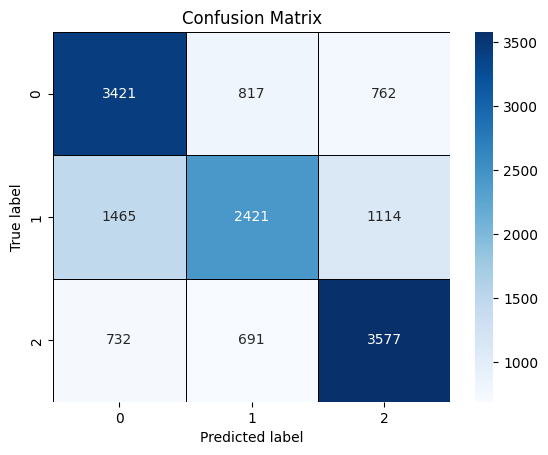

In [195]:
plot_ml_metrics(train_metrics);

Accuracy: 0.5583
W. Recall: 0.5583
W. Precision: 0.5561

Label: 0, Recall: 0.5364
Label: 0, Precision: 0.5364

Label: 1, Recall: 0.5316
Label: 1, Precision: 0.5316

Label: 2, Recall: 0.6004
Label: 2, Precision: 0.6004



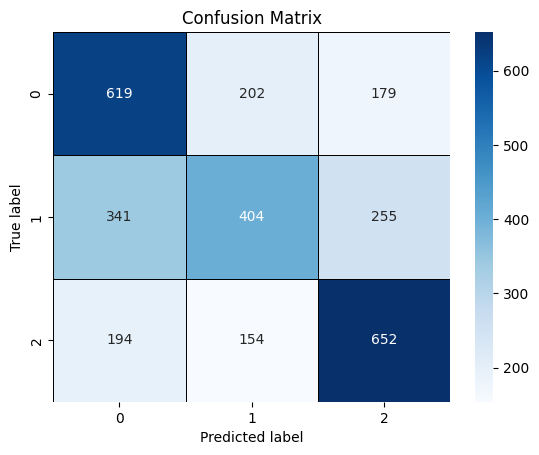

In [196]:
plot_ml_metrics(valid_metrics);

### 5.2. Cross Validation

Is possible to use a CrossValidator of PySpark or make manual K-Fold loops.

Steps of Cross Validation:

1. Random Sample Dataset into Train and Test;
2. Train dataset with Train sample and valid with Test;
3. Repeat K times;
4. Summarize Metrics;

But in multiclass problems, is impossible to random split, because you can imbalance classes, I will need to random split and have same classes proportions.

#### 5.2.1. Loop K Fold Cross Validation

In [51]:
df_train = df_train_idf.select(
    pf.col("id"),
    pf.col("features"),
    pf.col("score").alias("label")
)

df_valid = df_valid_idf.select(
    pf.col("id"),
    pf.col("features"),
    pf.col("score").alias("label")
)

# Join Train and Valid Datasets
df_cross = df_train.unionAll(df_valid)#.distinct()

# 80% for training and 20% for validation/test on k splits
validation_fractions = {
    0.0: 0.2,
    1.0: 0.2,
    2.0: 0.2
}

In [77]:
# Sample for Valid Dataset
df_valid_cross = df_cross.sampleBy(col="label", fractions=validation_fractions)

df_valid_cross.groupBy("label").agg(pf.count(pf.col("features"))).show()

+-----+---------------+
|label|count(features)|
+-----+---------------+
|    1|           1241|
|    0|           1169|
|    2|           1167|
+-----+---------------+



In [53]:
# Filter for Train Cross Dataset

df_train_cross = df_cross.join(
    df_valid_cross.select(
        pf.col("id"),
        pf.col("label").alias("t_label")
    ),
    on="id",
    how="left"
)

df_train_cross = df_train_cross.filter(pf.col("t_label").isNull())

df_train_cross = df_train_cross.select(
    pf.col("id"),
    pf.col("features"),
    pf.col("label")
)

In [72]:
rfc = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    maxDepth=5, 
    maxBins=32, 
    numTrees=100,
    minInfoGain=0.0, 
    impurity="gini",
    minInstancesPerNode=1,
    featureSubsetStrategy="auto"
)

rfc = rfc.fit(df_train_cross)

df_valid_results = rfc.transform(df_valid_cross)

df_valid_results = get_metrics(df_valid_results, "label")

23/09/09 14:31:22 WARN DAGScheduler: Broadcasting large task binary with size 1228.4 KiB


In [78]:
# Now i will repeat all process for K Times and Storange the metrics.

df_valid_results.weightedRecall

0.5912776069331842

In [32]:
# I made a function for do this K times

r = simple_cross_validation_k_times(
    k=5,
    df_cross=df_cross,
    validation_fractions=validation_fractions
)


Training Fold: 1



23/09/09 18:10:31 WARN DAGScheduler: Broadcasting large task binary with size 1208.7 KiB
/home/grc/arep/sentiment_analysis/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Training Fold: 2



23/09/09 18:11:12 WARN DAGScheduler: Broadcasting large task binary with size 1213.0 KiB



Training Fold: 3



23/09/09 18:11:52 WARN DAGScheduler: Broadcasting large task binary with size 1207.6 KiB



Training Fold: 4



23/09/09 18:12:32 WARN DAGScheduler: Broadcasting large task binary with size 1212.4 KiB



Training Fold: 5



23/09/09 18:13:11 WARN DAGScheduler: Broadcasting large task binary with size 1211.6 KiB


In [34]:
r

,fold,accuracy,recall,precision
0,1,0.589143,0.589143,0.604297
1,2,0.618687,0.618687,0.617507
2,3,0.593648,0.593648,0.599674
3,4,0.621795,0.621795,0.623236
4,5,0.618568,0.618568,0.617863


In [35]:
r.describe().T

,count,mean,std,min,25%,50%,75%,max
fold,5.0,3.000000,1.581139,1.000000,2.000000,3.000000,4.000000,5.000000
accuracy,5.0,0.608368,0.015629,0.589143,0.593648,0.618568,0.618687,0.621795
recall,5.0,0.608368,0.015629,0.589143,0.593648,0.618568,0.618687,0.621795
precision,5.0,0.612515,0.010011,0.599674,0.604297,0.617507,0.617863,0.623236


#### 5.2.2. PySpark Cross Validation

For PySpark CrossVal class, its require a ParamGrid.

In [47]:
# Base Estimator to fit, same previous estimator

rfc = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    maxDepth=5,
    maxBins=32, 
    numTrees=100,
    minInfoGain=0.0, 
    impurity="gini",
    minInstancesPerNode=1,
    featureSubsetStrategy="auto"
)

In [41]:
# Setup ParamGridBuilder Object
# Only with one param, because its not tuning step, my interest is only in cross validation

param_grid = ParamGridBuilder() \
             .addGrid(rfc.maxDepth, [5]) \
             .build()

In [42]:
# Define Evaluator Object

evaluator = MulticlassClassificationEvaluator()

In [ ]:
# This fit took ~3 Minute in my pc

cv = CrossValidator(
    numFolds=5,
    estimator=rfc,
    evaluator=evaluator,
    parallelism=5,
    estimatorParamMaps=param_grid
)

cv = cv.fit(df_train)

In [65]:
cv.bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_161df6867a38, numTrees=100, numClasses=3, numFeatures=5000

In [54]:
print(cv.explainParams())

df_valid_results = cv.transform(df_valid)

df_valid_results = get_metrics(df_valid_results, "label")

estimator: estimator to be cross-validated (current: RandomForestClassifier_161df6867a38)
estimatorParamMaps: estimator param maps (current: [{Param(parent='RandomForestClassifier_9ab7825beddf', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5}])
evaluator: evaluator used to select hyper-parameters that maximize the validator metric (current: MulticlassClassificationEvaluator_a37a332b0b0f)
foldCol: Param for the column name of user specified fold number. Once this is specified, :py:class:`CrossValidator` won't do random k-fold split. Note that this column should be integer type with range [0, numFolds) and Spark will throw exception on out-of-range fold numbers. (default: )
numFolds: number of folds for cross validation (default: 3, current: 5)
seed: random seed. (default: -8652328927185950209)


Accuracy: 0.5557
W. Recall: 0.5557
W. Precision: 0.5531

Label: 0, Recall: 0.5703
Label: 0, Precision: 0.5703

Label: 1, Recall: 0.5290
Label: 1, Precision: 0.5290

Label: 2, Recall: 0.5601
Label: 2, Precision: 0.5601



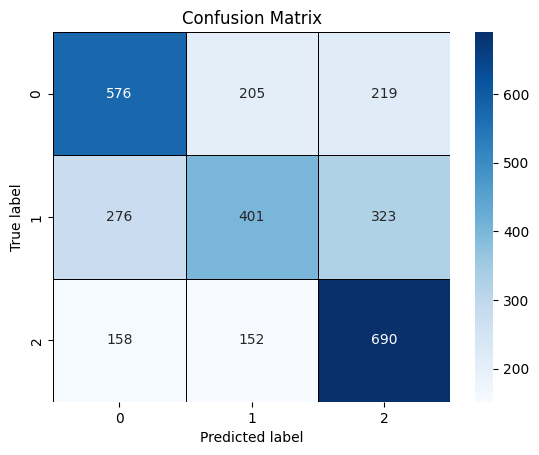

In [66]:
plot_ml_metrics(df_valid_results);

## 6.0. Model Tuning

Now its time to Fine tuning!

You can use Spark Ml CrossVal for tuning or use hyperopt.

### 6.1. Hyperopt

In [91]:
# I ill use prevous df_train of cross validation for tuning with Hyperopt.

df_train.show(5)

df_valid.show(5)

+-----+--------------------+-----+
|   id|            features|label|
+-----+--------------------+-----+
|46850|(5000,[114,524,89...|    1|
|50788|(5000,[133,153,20...|    1|
|51173|(5000,[524,843,95...|    1|
| 7129|(5000,[21,133,447...|    1|
| 8147|(5000,[133,415,16...|    1|
+-----+--------------------+-----+
only showing top 5 rows



+---+--------------------+-----+
| id|            features|label|
+---+--------------------+-----+
|  4|(5000,[533,631,73...|    1|
| 17|(5000,[433,855,90...|    1|
| 46|(5000,[80,524,664...|    1|
| 48|(5000,[288,354,90...|    1|
| 50|(5000,[80,264,569...|    1|
+---+--------------------+-----+
only showing top 5 rows



In [57]:
def objective(
    params,
    metric: str = "accuracy",
    df_train: DataFrame = df_train, # Default params for training
    df_valid: DataFrame = df_valid  # Default params for validation
):
    """
    Objective function to minimize with hyperopt.
    
    Inputs:
        - params: Hyperopt requested argument.
        - metric: Metric name for optimize.
        - df_train: DataFrame for training.
        - df_valid: DataFrame for validation (metric). 

    returns:
        - dict with score and status
    
    """

    print(params)

    model = RandomForestClassifier(**params)

    model = model.fit(df_train)

    df_valid_results = model.transform(df_valid)
    
    valid_metrics = get_metrics(df_valid_results, "label")

    # Wen you use fmin, expects a loss function to "minimize", instead whe use (-1 * accuracy).
    # With this, with "lower selected metric (accuracy) is better" (because is negative)

    if metric == "accuracy":
        score = -1 * valid_metrics.accuracy

    else:
        score = -1 * valid_metrics.weightedPrecision

    return {"loss": score, "status": STATUS_OK}

In [ ]:
# List of hyperparams for search

search_space = {
    "maxDepth": hp.quniform("maxDepth", 4, 20, 1), 
    "maxBins": hp.quniform("maxBins", 20, 100, 5), 
    "numTrees": hp.quniform("numTrees", 20, 300, 5),
    "impurity": hp.choice("impurity", ["gini", "entropy"]),
    "minInstancesPerNode": hp.quniform("minInstancesPerNode", 1, 5, 1)
}

# Spark Trials
#trials = SparkTrials(parallelism=5)

# Hyperopt Trials
trials = Trials()

best = fmin(
    fn=objective,       # Function to minimize
    algo=tpe.suggest,   # "Given previous trials and the domain, suggest the best expected hp point according to the TPE-EI algo"
    space=search_space, # Search params
    max_evals=50,       # Times of search
    trials=trials
)

In [45]:
# Best params for 50 fits
best = {'impurity': 'gini', 'maxBins': 65.0, 'maxDepth': 13.0, 'minInstancesPerNode': 3.0, 'numTrees': 50.0}

In [ ]:
rfc = RandomForestClassifier(
    featuresCol="features",
    labelCol="score",
    **best
)

rfc = rfc.fit(df_train_idf)

# Get Predictions
df_valid_results = rfc.transform(df_valid_idf)

# I have created a function too for get metrics for validation dataset
valid_metrics = get_metrics(df_valid_results)

23/09/10 13:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1283.6 KiB


Accuracy: 0.5670
W. Recall: 0.5670
W. Precision: 0.5660

Label: 0, Recall: 0.5509
Label: 0, Precision: 0.5509

Label: 1, Recall: 0.5533
Label: 1, Precision: 0.5533

Label: 2, Recall: 0.5938
Label: 2, Precision: 0.5938



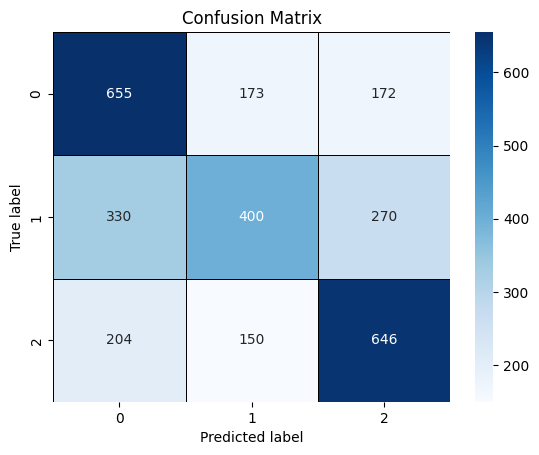

In [41]:
plot_ml_metrics(valid_metrics);

In [ ]:
r = simple_cross_validation_k_times(
    k=5,
    df_cross=df_cross,
    params_dict=best,
    validation_fractions=validation_fractions
)

In [53]:
r

,fold,accuracy,recall,precision
0,1,0.692918,0.692918,0.693493
1,2,0.680999,0.680999,0.682749
2,3,0.678167,0.678167,0.680925
3,4,0.676613,0.676613,0.680400
4,5,0.689097,0.689097,0.694761


In [54]:
r.describe().T

,count,mean,std,min,25%,50%,75%,max
fold,5.0,3.000000,1.581139,1.000000,2.000000,3.000000,4.000000,5.000000
accuracy,5.0,0.683559,0.007109,0.676613,0.678167,0.680999,0.689097,0.692918
recall,5.0,0.683559,0.007109,0.676613,0.678167,0.680999,0.689097,0.692918
precision,5.0,0.686465,0.007062,0.680400,0.680925,0.682749,0.693493,0.694761


### 6.2. Fit Last Estimator

Now, is time to fit estimator and classify on Test Dataset.

In [ ]:
# Production new texts for classify

df_test = df_test_idf.select(
    pf.col("id"),
    pf.col("features"),
    pf.col("score").alias("label")
)

In [ ]:
estimator = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    **best
)

# Fit last estimator
estimator = estimator.fit(df_cross)

In [73]:
# Get performance
test_results = estimator.transform(df_test)

In [ ]:
# Get Metrics on Test dataset
test_results = get_metrics(test_results, "label")

Accuracy: 0.6080
W. Recall: 0.6080
W. Precision: 0.6058

Label: 0, Recall: 0.5853
Label: 0, Precision: 0.5853

Label: 1, Recall: 0.5744
Label: 1, Precision: 0.5744

Label: 2, Recall: 0.6575
Label: 2, Precision: 0.6575



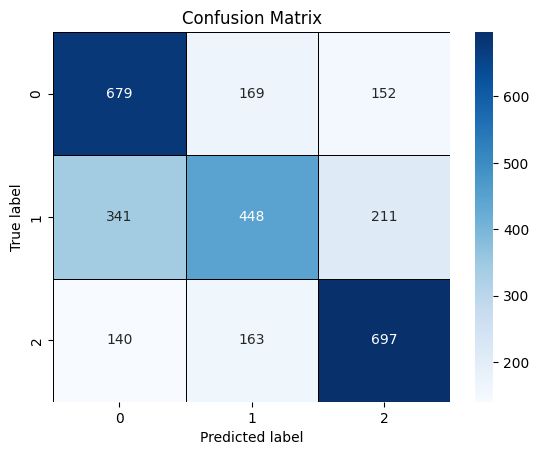

In [76]:
plot_ml_metrics(test_results);

In [77]:
# Time to save the model
estimator.write().save("../src/estimator/random_forest.spark")

## 7.0. PySpark Pipeline

To make the deployment script more simplified, I will use a Pyspark feature called Pipeline, it serves as a list of transformations that will then be applied until classification, for example, cleans, preparations, transformations and classification.

![Alt text](image-2.png)

In [48]:
# The first step is read some samples data for raw file

artifacts_path = "../src/features"
estimator_path = "../src/estimator"
base_path = "/home/grc/arep/sentiment_analysis/data/archive/"

df_raw = spark.read.format("csv")\
              .option("header", "true")\
              .option("inferSchema", "true")\
              .option("delimiter", ",") \
              .load(base_path + "Reviews.csv")


# Just a random sample for speed computations
# Maybe i can take train / valid data here with this proportions
# But this is just for simulate and make Pipeline

df_raw = df_raw.sample(0.05)

# The RAW (Production) New Data!

df_raw.show(5)

df_raw.count()

+---+----------+--------------+------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
| Id| ProductId|        UserId|       ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|
+---+----------+--------------+------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|  8|B006K2ZZ7K|A3JRGQVEQN31IQ|Pamela G. Williams|                   0|                     0|    5|1336003200|Wonderful, tasty ...|This taffy is so ...|
| 10|B00171APVA|A21BT40VZCCYT4|     Carol A. Reed|                   0|                     0|    5|1351209600|    Healthy Dog Food|This is a very he...|
| 13|B0009XLVG0| A327PCT23YH90|                LT|                   1|                     1|    1|1339545600|My Cats Are Not F...|My cats have been...|
| 33|B001EO5QW8| AOVROBZ8BNTP7|         S. Potter|                  19|     

28401

### 7.1. Manual Simulation of Production Pipeline

In [121]:
# Load Artifacts

idf = IDFModel.load(artifacts_path + "/idf.spark/")
hashing = HashingTF.load(artifacts_path + "/hashing.spark/")
tokenizer = Tokenizer.load(artifacts_path + "/tokenizer.spark")
stopwords = StopWordsRemover.load(artifacts_path + "/stopwords.spark")

estimator = RandomForestClassificationModel.load(estimator_path + "/random_forest.spark")

In [185]:
# Data Cleaning

# First is clean Noise data and create labels
df1 = noise_removal(df_raw)

# Second if the text preprocessing
df2 = preprocessing_text_data(
    dataframe=df1,
    text_col="text"
)

In [186]:
# Apply Transformations

df2 = tokenizer.transform(df2)

df2 = stopwords.transform(df2)

df2 = hashing.transform(df2)

df2 = idf.transform(df2)

In [188]:
# Get Prediction and Probas

df3 = estimator.transform(df2)

df3 = df3.select(
    pf.col("id").alias("Id"), # For Join
    pf.col("label"),
    pf.col("probability"),
    pf.col("prediction")
)

23/09/10 17:22:50 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/09/10 17:22:51 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


+----------+-----+
|prediction|    c|
+----------+-----+
|       1.0| 5785|
|       0.0| 6665|
|       2.0|15789|
+----------+-----+

+-----+-----+
|label|    c|
+-----+-----+
|    0| 2556|
|    1| 3552|
|    2|22131|
+-----+-----+



/home/grc/arep/sentiment_analysis/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/09/10 17:22:52 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/09/10 17:22:53 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


Accuracy: 0.6384
W. Recall: 0.6384
W. Precision: 0.7845

Label: 0, Recall: 0.2744
Label: 0, Precision: 0.2744

Label: 1, Recall: 0.2755
Label: 1, Precision: 0.2755

Label: 2, Recall: 0.9251
Label: 2, Precision: 0.9251



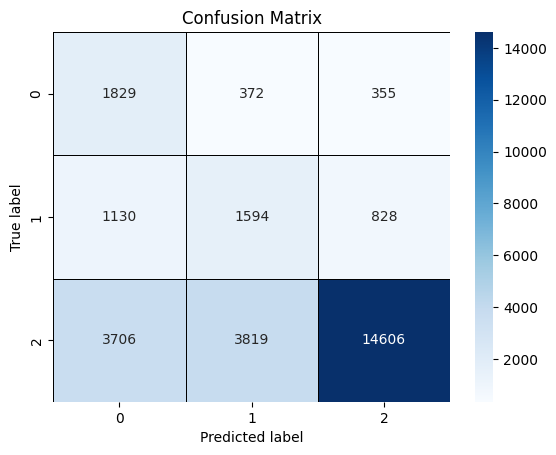

In [177]:
# This is the performance of estimator in production :(

df3.groupBy("prediction").agg(pf.count("Id").alias("c")).orderBy("c").show()
df2.groupBy("label").agg(pf.count("id").alias("c")).orderBy("c").show()

m = get_metrics(df3, y_col="label")

plot_ml_metrics(m);

In [173]:
# Join Raw data with Model Predictions
df_raw_with_probas = df_raw.join(
    df3,
    on="Id",
    how="inner"
)

# This is the last Dataframe with "fresh / new" reviews and their respectives scores

df_raw_with_probas.select(
    pf.col("Id"),
    pf.col("ProductId"),
    pf.col("UserId"),
    pf.col("ProfileName"),
    pf.col("HelpfulnessNumerator"),
    pf.col("HelpfulnessDenominator"),
    # pf.col("Score"), # Simulation New Reviews
    pf.col("Time"),
    pf.col("Summary"),
    pf.col("Text"),
    pf.col("label").alias("ModelScore"),
    pf.col("probability").alias("ModelProbaScore"),
    pf.col("prediction").alias("ModelPrediction") # Max Proba is Score Label
).show(
    3,
    truncate=False
)

23/09/10 17:19:14 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


+---+----------+--------------+---------------------------------+--------------------+----------------------+----------+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------------------------------------------------------+---------------+
|Id |ProductId |UserId        |ProfileName                      |HelpfulnessNumerator|HelpfulnessDenominator|Time      |Summary           |Text                                                                                                                                               |ModelScore|ModelProbaScore                                             |ModelPrediction|
+---+----------+--------------+---------------------------------+--------------------+----------------------+----------+------------------+-------------------------------------------------------------------------------------------------------------

### 7.2. PySpark Pipeline Overview

In [193]:
# Lets start fixing two functions
# This two functions is created by me, i will need to transform this functions to be hable to input inside Pipeline 

# First is clean Noise data and create labels
df1 = noise_removal(df_raw)

# Second if the text preprocessing
df2 = preprocessing_text_data(
    dataframe=df1,
    text_col="text"
)

The basic idea is to create a list of tasks that will be transformed by the pipeline, and finally, initialize this pipeline with the transform method.

As shown in the image, there are some steps that can be included in the pipeline.

[] -> tokenizer -> stopwords -> hashing -> idf -> estimator

But, I have a problem, i need to clean and preprocess data in start of the pipeline, but I cannot use base functions in spark Pipeline class, i need to transform this functions in a "Class of Transformer" to input in spark Pipeline. 

In [ ]:
# Steps List
stages = [tokenizer, stopwords, hashing, idf, estimator]

# Definition of Pipeline
pipeline = Pipeline(
    stages=stages
)

# Fit the pipeline
pipeline = pipeline.fit(df2)

# Transform the pipeline
df3 = pipeline.transform(df2)

Now I need to transform simple python functions to a pyspark transformer class.

To do that, I only need the Transformer base class on my new transformer class, In short, "Transformer" it is a Python ABC with another extra class ("Param") with some methods already created to help us! 

In [36]:
from pyspark.ml import Transformer

# The Basic Class example

class BasicExample(Transformer):

    # Python Init Class
    # The "UserInputParam" is just a user param like "inputCol"

    def __init__(self, UserInputParam: str = "World"):
        self.UserInputParam = UserInputParam

    # Transform method from Transformer class
    # Its required a DataFrame object called "dataset" in input of transform

    def _transform(self, dataset: DataFrame):
        print(f"Hello {self.UserInputParam}!")
        

# Instanciate the class
example = BasicExample(UserInputParam="WORLD")

# Call transformer!
example.transform(dataset=DataFrame)

Hello WORLD!


The basic idea is this *BasicExample*, now let's write for our objective, which is to transform the label column and clean the data.

In [31]:
class NoiseRemoval(Transformer):
    """
    This class is responsible for filtering wrong Scores
    and for create label class associated with the scores.

    inputs:
        - inputCol: Column that will be transformed.
        - outputCol: Output Column name.
        - labelCol: Label / Score column to generate Bad, Neutral or Good label.

    returns:
        - df: Transformed DataFrame. 

    """

    def __init__(
        self,
        inputCol: str = "Text",
        outputCol: str = "Text",
        labelCol: str = "Score"
    ):

        self.inputCol = inputCol
        self.outputCol = outputCol
        self.labelCol = labelCol

    # Transform
    def _transform(self, dataset: DataFrame) -> DataFrame:
        y_col = self.labelCol
        
        if y_col not in dataset.columns:
            raise AnalysisException(f"'{y_col}' column not exists on DataFrame")

        df = dataset.filter(pf.col(y_col).isin([0, 1, 2, 3, 4, 5]))

        # Good, Neutral and Bad
        df = df.withColumn(
            "new_score",
            pf.when(pf.col(y_col) == 1, 0)\
            .when((pf.col(y_col) > 1) & (pf.col(y_col) <= 3), 1) \
            .when(pf.col(y_col) > 3, 2)
        )

        df = df.filter(pf.col("new_score").isin([0, 1, 2]))

        df = df.select(
            pf.col("Id"),
            pf.col("new_score").alias("label"),
            pf.col(self.inputCol).alias(self.outputCol)
        )

        return df

In [46]:
noise_removal = NoiseRemoval(
    inputCol="Text",
    outputCol="Text",
    labelCol="Score"
)

In [29]:
# In a list, i set the Stages of Pipeline
stages = [noise_removal]

# Instance for pipeline class and definition of which steps will be start in the list of stages
pipeline = Pipeline(
    stages=stages
)

# Fit the pipeline function
pipeline = pipeline.fit(df_raw)

# And transform!
df_clean = pipeline.transform(df_raw)

# Its Worked!
df_clean.show(5)

+---+-----+--------------------+
| Id|label|                Text|
+---+-----+--------------------+
|  2|    0|"Product arrived ...|
| 32|    2|This offer is a g...|
| 57|    2|Deal was awesome!...|
|118|    2|In the 1980s I sp...|
|123|    2|I have a 4 year o...|
+---+-----+--------------------+
only showing top 5 rows



Now let's create the next transformation class which is to clean the data

In [67]:
class CleanRawText(Transformer):
    """
    This class is responsible for cleaning text data.

    inputs:
        - inputCol: Column that will be transformed.
        - outputCol: Output Column name.

    returns:
        - df: Transformed DataFrame. 

    """

    def __init__(
        self,
        textCol: str = "Text"
    ):

        self.textCol = textCol

    # Transform!
    def _transform(self, dataset: DataFrame) -> DataFrame:
        text_col = self.textCol

        # Normalization and remove minor wrongs
        df = dataset.withColumn(
            text_col,
            pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.lower(pf.trim(pf.col(text_col))), '"', ""), "  ", " "), "  ", " ")
        )

        # Remove Tags and Especial Chars
        df = df.withColumn(
            text_col,
            pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.col(text_col), "'", ""), "<br /><br />", ""), "<br />", ""), "\'", "'"), "<a href=", "")
        )

        # Fix Wrong writes
        df = df.withColumn(
            text_col,
            pf.regexp_replace(pf.col(text_col), " u ", " you ")
        )

        # Remove Extra Simbols and Site URL'S
        df = df.withColumn(
            text_col,
            pf.regexp_replace(pf.regexp_replace(pf.regexp_replace(pf.col(text_col), "http\S+", ""), "https\S+", ""), "  ", " ")
        )

        return df

In [43]:
clean_text = CleanRawText(
    inputCol="Text",
    textCol="Text"
)

df_clean_but_two = clean_text.transform(df_clean)

df_clean.show(2, truncate=False)

df_clean_but_two.show(2, truncate=False)

+---+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Id |label|Text                                                                                                                                                                                              |
+---+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2  |0    |"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."|
|32 |2    |This offer is a great price and a great taste, thanks Amazon for selling this product.<br /><br />Staral                                                         

Looks like working, lets try to put all pieces together!

### 7.3. PySpark Pipeline

In [ ]:
# Load Artifacts

idf = IDFModel.load(artifacts_path + "/idf.spark/")
hashing = HashingTF.load(artifacts_path + "/hashing.spark/")
tokenizer = Tokenizer.load(artifacts_path + "/tokenizer.spark")
stopwords = StopWordsRemover.load(artifacts_path + "/stopwords.spark")

estimator = RandomForestClassificationModel.load(estimator_path + "/random_forest.spark")

In [69]:
# Setup Custom Transformers

noise_removal = NoiseRemoval(
    inputCol="Text",
    outputCol="text", # Lowercase "Text" for tokenizer, because I previous save with lowercase :P
    labelCol="Score"
)

clean_text = CleanRawText(
    textCol="text"
)

In [74]:
stages = [
    noise_removal,
    clean_text,
    tokenizer,
    stopwords,
    hashing,
    idf,
    estimator
]

# Definition of Pipeline
pipeline = Pipeline(
    stages=stages
)

# Fit the pipeline
pipeline = pipeline.fit(df_raw)

# Transform the pipeline
df = pipeline.transform(df_raw)

In [75]:
# Worked!

df.show(5)

+---+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| Id|label|                text|              tokens|               words|        raw_features|            features|       rawPrediction|         probability|prediction|
+---+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  8|    2|this taffy is so ...|[this, taffy, is,...|[taffy, good., so...|(5000,[324,1670,1...|(5000,[324,1670,1...|[33.2148692608466...|[0.33214869260846...|       2.0|
| 10|    2|this is a very he...|[this, is, a, ver...|[healthy, dog, fo...|(5000,[32,222,633...|(5000,[32,222,633...|[32.7436624353972...|[0.32743662435397...|       2.0|
| 13|    0|my cats have been...|[my, cats, have, ...|[cats, happily, e...|(5000,[150,237,30...|(5000,[150,237,30...|[33.6136180796685...|[0.3361361807

23/09/11 08:45:38 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


In [82]:
# Join Raw data with Model Predictions
df_raw_with_probas = df_raw.join(
    df.select(
        pf.col("Id"),
        pf.col("label"),
        pf.col("probability"),
        pf.col("prediction")
    ),
    on="Id",
    how="inner"
)

# This is the last Dataframe with "fresh / new" reviews and their respectives scores
df_raw_with_probas.select(
    pf.col("Id"),
    pf.col("ProductId"),
    pf.col("UserId"),
    pf.col("ProfileName"),
    pf.col("HelpfulnessNumerator"),
    pf.col("HelpfulnessDenominator"),
    # pf.col("Score"), # Simulation New Reviews
    pf.col("Time"),
    pf.col("Summary"),
    pf.col("Text"),
    pf.col("label").alias("ModelScore"),
    pf.col("probability").alias("ModelProbaScore"),
    pf.col("prediction").alias("ModelPrediction") # Max Proba is Score Label
).show(
    3,
    truncate=False
)

23/09/11 08:49:21 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


+---+----------+--------------+------------------+--------------------+----------------------+----------+------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+-------------------------------------------------------------+---------------+
|Id |ProductId |UserId        |ProfileName       |HelpfulnessNumerator|HelpfulnessDenominator|Time      |Summary                             |Text                                                                                                                                                                                                                              

23/09/11 08:47:07 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


+----------+-----+
|prediction|    c|
+----------+-----+
|       1.0| 5863|
|       0.0| 6721|
|       2.0|15719|
+----------+-----+

+-----+-----+
|label|    c|
+-----+-----+
|    0| 2658|
|    1| 3666|
|    2|21979|
+-----+-----+



/home/grc/arep/sentiment_analysis/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/09/11 08:47:08 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/09/11 08:47:09 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


Accuracy: 0.6390
W. Recall: 0.6390
W. Precision: 0.7820

Label: 0, Recall: 0.2817
Label: 0, Precision: 0.2817

Label: 1, Recall: 0.2777
Label: 1, Precision: 0.2777

Label: 2, Recall: 0.9266
Label: 2, Precision: 0.9266



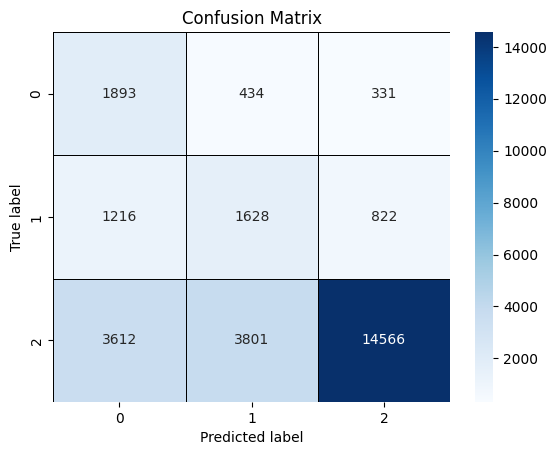

In [76]:
# This is the performance of estimator in production :(
df.groupBy("prediction").agg(pf.count("Id").alias("c")).orderBy("c").show()
df.groupBy("label").agg(pf.count("id").alias("c")).orderBy("c").show()

m = get_metrics(df, y_col="label")

plot_ml_metrics(m);